#1.Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Grammatical_Error_correction/

/content/drive/MyDrive/Grammatical_Error_correction


#2.Imports and installations

In [ ]:
import os
import io
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#3.Define Constants

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Grammatical_Error_correction/Data/csv_data/lang8/lang8_anno_id0_preprocessed_word.csv'
CSV_PATH = '/content/drive/MyDrive/Grammatical_Error_correction/Data/csv_data/lang8'
MAX_SEQ_LEN = 10 #50th percentile of incorrect sentence length
START_TOKEN = '<start>'
END_TOKEN = '<end>'

#4.Read Data and Prepare data for model

In [ ]:
data = pd.read_csv(DATA_PATH)
data.shape

(929615, 7)

In [ ]:
data.head()

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len,incorrect_word_len,correct_word_len
0,good luck on your new start !,good luck on your new start !,0,29,29,7,7
1,my teacher is going to move to change his job .,my teacher is going to move to change his job .,0,47,47,11,11
2,he is a so nice guy and taught me english very...,he is a so nice guy and taught me english very...,0,106,106,23,23
3,and he took in my favorite subjects like soccer .,and he took in my favorite subject like soccer .,1,48,49,10,10
4,"actually , he was the one who let me know abou...","actually , who let me know about lang was him .",2,49,58,11,14


In [ ]:
data = data[data['incorrect_word_len'] <= MAX_SEQ_LEN]
data.shape

(470503, 7)

In [ ]:
data['total_edits'].value_counts(sort=True)

0     265930
1     105284
2      58520
3      26688
4       9872
5       3052
6        871
7        209
8         49
9         14
10         7
11         4
16         1
14         1
13         1
Name: total_edits, dtype: int64

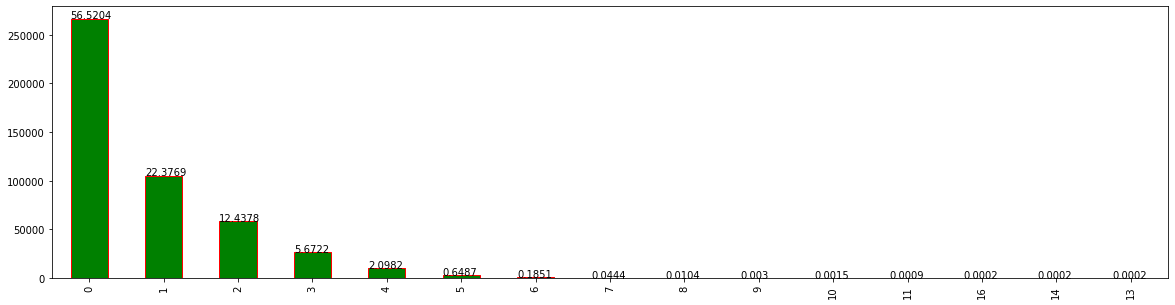

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
data['total_edits'].value_counts().plot(kind='bar', ax=ax, edgecolor='red', color='green')

for p in ax.patches:
  value = np.round(p.get_height() * 100/data.shape[0], 4)
  ax.annotate(str(value), (p.get_x(), p.get_height() * 1.005))

**Observation**: <br> 
1. Majority of sentences (half of the data points in our dataset) has total edits = 0, that is incorrect sentences == correct sentence.
2. This will make the model bias. that is, it always gives output as same as input. 
3. Hence we need to decrease this count

In [ ]:
data2 = data.drop(data[data['total_edits'] == 0].sample(frac=0.98).index, inplace=False) #dropping 95% of data points whose total edits = 0
data2.shape

(209892, 7)

In [ ]:
data2['total_edits'].value_counts(sort=True)

1     105284
2      58520
3      26688
4       9872
0       5319
5       3052
6        871
7        209
8         49
9         14
10         7
11         4
16         1
14         1
13         1
Name: total_edits, dtype: int64

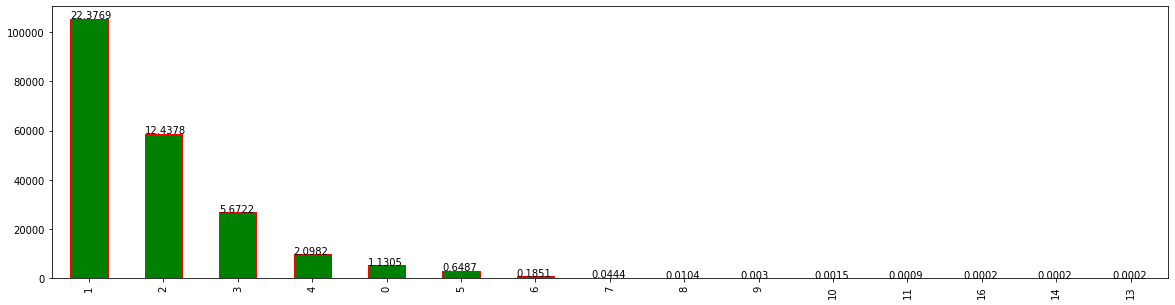

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
data2['total_edits'].value_counts().plot(kind='bar', ax=ax, edgecolor='red', color='green')

for p in ax.patches:
  value = np.round(p.get_height() * 100/data.shape[0], 4)
  ax.annotate(str(value), (p.get_x(), p.get_height() * 1.005))

In [ ]:
data2.reset_index(inplace=True, drop=True)
data2.shape

(209892, 7)

#5.Train validation and Test split

In [ ]:
train, test = train_test_split(data2, test_size=0.05)
train, validation = train_test_split(train, test_size = 0.1)


print("SHAPES")
print("="*100)
print("Train: ", train.shape)
print("Validation: ", validation.shape)
print("Test: ", test.shape)

SHAPES
Train:  (179457, 7)
Validation:  (19940, 7)
Test:  (10495, 7)


In [ ]:
train.head()

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len,incorrect_word_len,correct_word_len
91083,it has been raining almost all day long today .,i has been raining almost all day long today .,1,46,47,10,10
198663,"yesterday , it was raining .","yester day , it was raining .",2,29,28,7,6
186376,heaven is over . . . .,heven is over . . . .,1,21,22,7,7
195242,"i thought , `` how frustrating ! ``",i thought how frustrating ! !,2,29,35,6,8
107407,"i know how to make a good coffee now ,",i know to make a good coffee now .,2,34,38,9,10


In [ ]:
validation.head()

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len,incorrect_word_len,correct_word_len
119132,i am a college student from china .,i am a college student frome china .,1,36,35,8,8
47253,the first day in lang,the first day in lang,0,21,21,5,5
291,i dreamed about her the night before yesterday .,i dreamed her the night before yesterday .,1,42,48,8,9
55531,today is topic was `` the circulatory system ...,today is topic was `` the circulatory system ...,4,50,51,10,10
28429,my husband took some photographs during the su...,"when operating , my husband took the photograph .",4,49,53,9,9


In [ ]:
train.to_csv(os.path.join(CSV_PATH, 'train.csv'), index=False)
validation.to_csv(os.path.join(CSV_PATH, 'validation.csv'), index=False)
test.to_csv(os.path.join(CSV_PATH, 'test.csv'), index=False)

In [ ]:
#load 
train = pd.read_csv(os.path.join(CSV_PATH, 'train.csv'))
validation = pd.read_csv(os.path.join(CSV_PATH, 'validation.csv'))
test = pd.read_csv(os.path.join(CSV_PATH, 'test.csv'))

sample = pd.read_csv(os.path.join(CSV_PATH, 'train.csv'), nrows=16)

#6.Tokenization

In [ ]:
train['decoder_inp'] = START_TOKEN + ' ' + train['correct'].astype(str)
train['decoder_out'] = train['correct'].astype(str) +' ' + END_TOKEN

validation['decoder_inp'] = START_TOKEN + ' ' + validation['correct'].astype(str)
validation['decoder_out'] = validation['correct'].astype(str) + ' ' + END_TOKEN


sample['decoder_inp'] = START_TOKEN + ' ' + sample['correct'].astype(str)
sample['decoder_out'] = sample['correct'].astype(str) + ' ' + END_TOKEN

In [ ]:
train.head(2)

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len,incorrect_word_len,correct_word_len,decoder_inp,decoder_out
0,it has been raining almost all day long today .,i has been raining almost all day long today .,1,46,47,10,10,<start> it has been raining almost all day lon...,it has been raining almost all day long today ...
1,"yesterday , it was raining .","yester day , it was raining .",2,29,28,7,6,"<start> yesterday , it was raining .","yesterday , it was raining . <end>"


In [ ]:
validation.head(2)

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len,incorrect_word_len,correct_word_len,decoder_inp,decoder_out
0,i am a college student from china .,i am a college student frome china .,1,36,35,8,8,<start> i am a college student from china .,i am a college student from china . <end>
1,the first day in lang,the first day in lang,0,21,21,5,5,<start> the first day in lang,the first day in lang <end>


In [ ]:
tokenizer_encoder = Tokenizer(filters='', lower=True)
tokenizer_encoder.fit_on_texts(train['incorrect'].values.tolist())

tokenizer_decoder = Tokenizer(filters='', lower=True)
tokenizer_decoder.fit_on_texts(train['decoder_inp'].values.tolist())

In [ ]:
print(f'Vocab size of encoder is: {len(tokenizer_encoder.word_index)}')
print(f'Vocab size of decoder is: {len(tokenizer_decoder.word_index)}')

Vocab size of encoder is: 37462
Vocab size of decoder is: 29022


In [ ]:
tokenizer_decoder.word_index[START_TOKEN], tokenizer_decoder.word_index.get(END_TOKEN, None)

(1, None)

**Observation:** <br> 
1. We can see Encoder tokenizer size is more than Decoder tokenizer size. 
2. This is because encoder contains misspelling words.
3. We do not have index for \<END\> token, lets add it


In [ ]:
 tokenizer_decoder.word_index[END_TOKEN] = len(tokenizer_decoder.word_index) + 1
 print(f'Vocab size of decoder is: {len(tokenizer_decoder.word_index)}')

 print("\n\n")
 tokenizer_decoder.word_index[START_TOKEN], tokenizer_decoder.word_index.get(END_TOKEN, None)

Vocab size of decoder is: 29023





(1, 29023)

In [ ]:
#save 

with open('./checkpoints/lang8/tokenizer_encoder_word_level.pickle', 'wb') as fp:
  pickle.dump(tokenizer_encoder, fp)

with open('./checkpoints/lang8/tokenizer_decoder_word_level.pickle', 'wb') as fp:
  pickle.dump(tokenizer_decoder, fp)

In [ ]:
# #load

# with open('./checkpoints/lang8/tokenizer_encoder_word_level.pickle', 'rb') as fp:
#   tokenizer_encoder = pickle.load(fp)

# with open('./checkpoints/lang8/tokenizer_decoder_word_level.pickle','rb') as fp:
#   tokenizer_decoder = pickle.load(fp)

In [ ]:
#training dataset
train_encoder_inp = tokenizer_encoder.texts_to_sequences(train['incorrect'].values.tolist())
train_decoder_inp = tokenizer_decoder.texts_to_sequences(train['decoder_inp'].values.tolist())
train_decoder_out = tokenizer_decoder.texts_to_sequences(train['decoder_out'].values.tolist())

#for decoder inp and output +1 is added, because of <start> and <end> token
train_encoder_inp = pad_sequences(train_encoder_inp, maxlen=MAX_SEQ_LEN, dtype='int32', padding='post', truncating='post', value=0)
train_decoder_inp = pad_sequences(train_decoder_inp, maxlen=MAX_SEQ_LEN+1, dtype='int32', padding='post', truncating='post', value=0)
train_decoder_out = pad_sequences(train_decoder_out, maxlen=MAX_SEQ_LEN+1, dtype='int32', padding='post', truncating='post', value=0)


#validation dataset
validation_encoder_inp = tokenizer_encoder.texts_to_sequences(validation['incorrect'].values.tolist())
validation_decoder_inp = tokenizer_decoder.texts_to_sequences(validation['decoder_inp'].values.tolist())
validation_decoder_out = tokenizer_decoder.texts_to_sequences(validation['decoder_out'].values.tolist())

validation_encoder_inp = pad_sequences(validation_encoder_inp, maxlen=MAX_SEQ_LEN, dtype='int32', padding='post', truncating='post', value=0)
validation_decoder_inp = pad_sequences(validation_decoder_inp, maxlen=MAX_SEQ_LEN+1, dtype='int32', padding='post', truncating='post', value=0)
validation_decoder_out = pad_sequences(validation_decoder_out, maxlen=MAX_SEQ_LEN+1, dtype='int32', padding='post', truncating='post', value=0)

In [ ]:
sample_encoder_inp = tokenizer_encoder.texts_to_sequences(sample['incorrect'].values.tolist())
sample_decoder_inp = tokenizer_decoder.texts_to_sequences(sample['decoder_inp'].values.tolist())
sample_decoder_out = tokenizer_decoder.texts_to_sequences(sample['decoder_out'].values.tolist())

sample_encoder_inp = pad_sequences(sample_encoder_inp, maxlen=MAX_SEQ_LEN, dtype='int32', padding='post', truncating='post', value=0)
sample_decoder_inp = pad_sequences(sample_decoder_inp, maxlen=MAX_SEQ_LEN+1, dtype='int32', padding='post', truncating='post', value=0)
sample_decoder_out = pad_sequences(sample_decoder_out, maxlen=MAX_SEQ_LEN+1, dtype='int32', padding='post', truncating='post', value=0)

In [ ]:
#save 
np.save('./Data/numpy_array/train_encoder_inp.npy', train_encoder_inp)
np.save('./Data/numpy_array/train_decoder_inp.npy', train_decoder_inp)
np.save('./Data/numpy_array/train_decoder_out.npy', train_decoder_out)

np.save('./Data/numpy_array/validation_encoder_inp.npy', validation_encoder_inp)
np.save('./Data/numpy_array/validation_decoder_inp.npy', validation_decoder_inp)
np.save('./Data/numpy_array/validation_decoder_out.npy', validation_decoder_out)

In [ ]:
np.save('./Data/numpy_array/sample_encoder_inp.npy', sample_encoder_inp)
np.save('./Data/numpy_array/sample_decoder_inp.npy', sample_decoder_inp)
np.save('./Data/numpy_array/sample_decoder_out.npy', sample_decoder_out)

#7.FastText Embeddings

In [ ]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    print(f"There are {n} number of words and their representation dim is {d} \n\n")
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(tokens[1:]), dtype='float32')
    return data

fasttext_fname = './wiki-news-300d-1M-subword.vec'

fasttext_word2vec = load_vectors(fasttext_fname)

There are 999994 number of words and their representation dim is 300 




999994it [01:39, 10001.61it/s]


In [ ]:
encoder_emb_matrix = np.zeros(shape=(len(tokenizer_encoder.word_index)+1,300)) #+1 is added to include PAD token
decoder_emb_matrix = np.zeros(shape=(len(tokenizer_decoder.word_index)+1,300)) #+1 is added to include PAD token

not_found = 0
not_found_list = []
for word, idx in tqdm(tokenizer_encoder.word_index.items()):
  vec = fasttext_word2vec.get(word)
  if vec is not None:
     encoder_emb_matrix[idx] = vec
  else:
    not_found+=1
    not_found_list.append(word)

print("\n")
print(f'{not_found} number of words did not got representation from FastText library')
print(f'{np.round((not_found/len(tokenizer_encoder.word_index))*100,2)} % of words did not got representation from FastText library')

100%|██████████| 37462/37462 [00:00<00:00, 440431.49it/s]



13113 number of words did not got representation from FastText library
35.0 % of words did not got representation from FastText library


In [ ]:
not_found = 0
not_found_list_de = []
for word, idx in tqdm(tokenizer_decoder.word_index.items()):
  vec = fasttext_word2vec.get(word)
  if vec is not None:
     decoder_emb_matrix[idx] = vec
  else:
    not_found+=1
    not_found_list_de.append(word)

print("\n")
print(f'{not_found} number of words did not got representation from FastText library')
print(f'{np.round((not_found/len(tokenizer_decoder.word_index))*100,2)} % of words did not got representation from FastText library')

100%|██████████| 29023/29023 [00:00<00:00, 399879.39it/s]



6964 number of words did not got representation from FastText library
23.99 % of words did not got representation from FastText library


In [ ]:
np.save('./Data/numpy_array/encoder_embeddings.npy', encoder_emb_matrix)
np.save('./Data/numpy_array/decoder_embeddings.npy', decoder_emb_matrix)